# ML Project: Classification 

## Predict what has the most influence over income 

- Education vs Salary
- Sex vs Salary 
- Race vs Salary
- Native-Country vs Salary

$50K/yr based on census data

Authors:
`Andrea Murphy` and `Josh Quigley`

## Setup

In [1]:
%matplotlib inline
import random

import pandas as pd
from pandas import Series,DataFrame
import numpy as np

from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [2]:
import pylab as plot
params = { 
    "axes.labelsize": "large",
    "xtick.labelsize" : "x-large",
    "legend.fontsize": 20,
    "figure.dpi": 150,
    "figure.figsize" : [25, 7]
}
plot.rcParams.update(params)

In [3]:

data = pd.read_csv('data/adult.data.txt')
test_data = pd.read_csv('data/adult.test.txt') 

data.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race",
                           "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "salary"]
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0


In [4]:
data.tail()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0
32559,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,1


In [5]:
type(data.index)

pandas.core.indexes.range.RangeIndex

In [6]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
salary            0
dtype: int64

## Education (and Age) vs Salary 

In [7]:
# drop columns won't be useful in analysis and prediction
data_education = data.drop(['fnlwgt', 'hours-per-week', 'native-country', 'sex', 'race', 'education', 'relationship', 'occupation', 'marital-status', 'workclass', 'capital-gain', 'capital-loss'], axis=1)

In [8]:
# sample 10000 random entries to train
data_education = data_education.sample(n=10000)

In [9]:
#Let's see what's left
data_education.head()

,age,education-num,salary
14222,42,9,0
6313,31,9,0
6167,23,10,0
24771,36,10,0
6800,29,9,0


In [10]:
data_education.shape

(10000, 3)

In [11]:
data_education["education-num"].value_counts()

9     3201
10    2212
13    1682
14     550
11     404
7      375
12     332
6      276
4      195
15     184
5      165
16     129
8      123
3      109
2       45
1       18
Name: education-num, dtype: int64

The 3 largest categories are Highschool Graduates (education-num 9), Some College Education (education-num 10), and Bachelors Degrees (education-num 13). 

In [12]:
#X Train and y-train have 70000 records of education-num and age and y-train has 70000 records of salary.
#X Test has 3000 withheld records on education-num and age and y-test has 3000 records of salary.

X_train = data_education.iloc[:7000]
X_train = X_train.drop(['salary'], axis=1)

X_test = data_education.iloc[7000:]
X_test = X_test.drop(['salary'], axis=1)

y_train = data_education.iloc[:7000]
y_train = y_train['salary']

y_test = data_education.iloc[7000:]
y_test = y_test['salary']

### Decision Tree

In [13]:
#Now we train using a Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

In [14]:
start_time = time()
tree_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.01s


<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

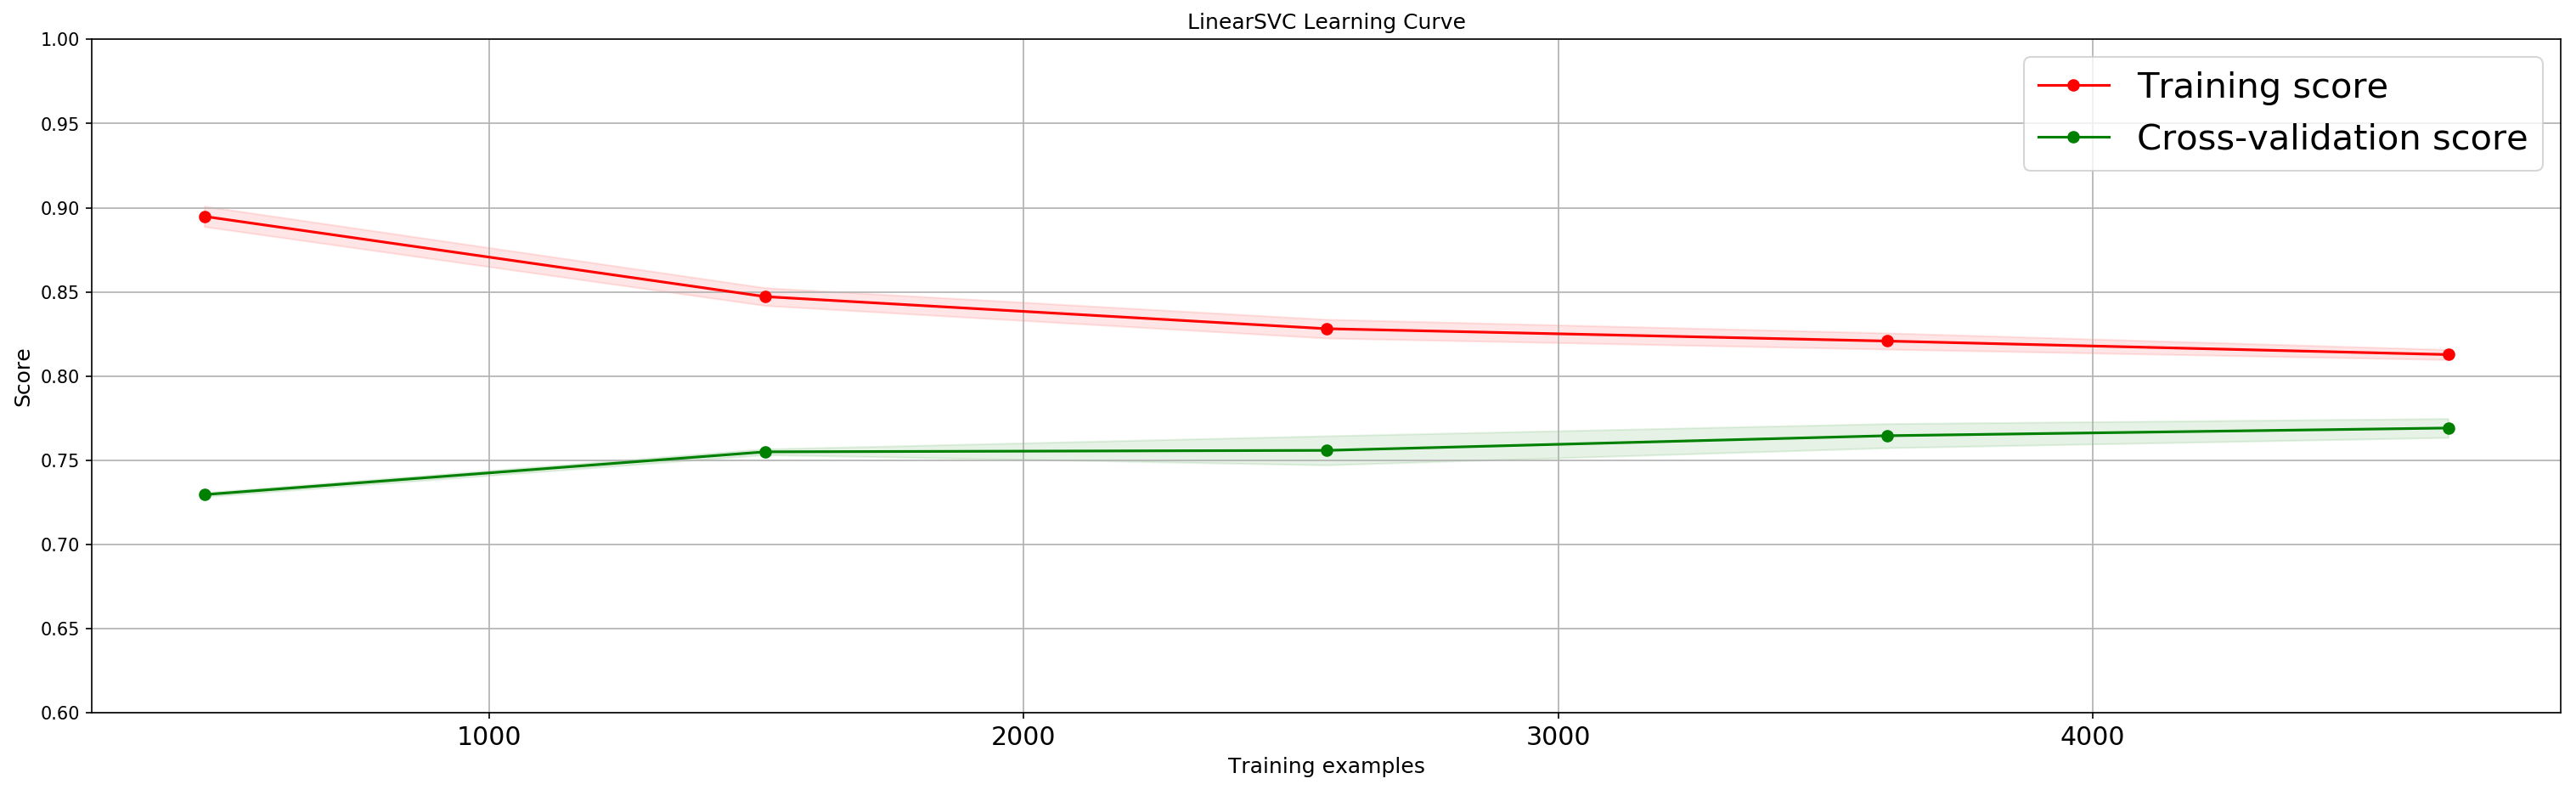

In [15]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.6, 1.0), cv=3)   

In [16]:
# Cross Validated Accuracy - the proportion of prediction the model got right

from sklearn.model_selection import cross_val_score
cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.76478149, 0.7651093 , 0.77711102])

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred_tree_clf = cross_val_predict(tree_clf, X_train, y_train, cv=3)

In [18]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives, True Positives
# True Negatives, False Positives

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred_tree_clf)

array([[4869,  435],
       [1181,  515]])

In [19]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

from sklearn.metrics import precision_score, recall_score
cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="precision")

array([0.52507375, 0.52631579, 0.5732899 ])

In [20]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="recall")

array([0.31448763, 0.28495575, 0.31150442])

#### Test Data

In [21]:
y_pred_tree_clf = tree_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

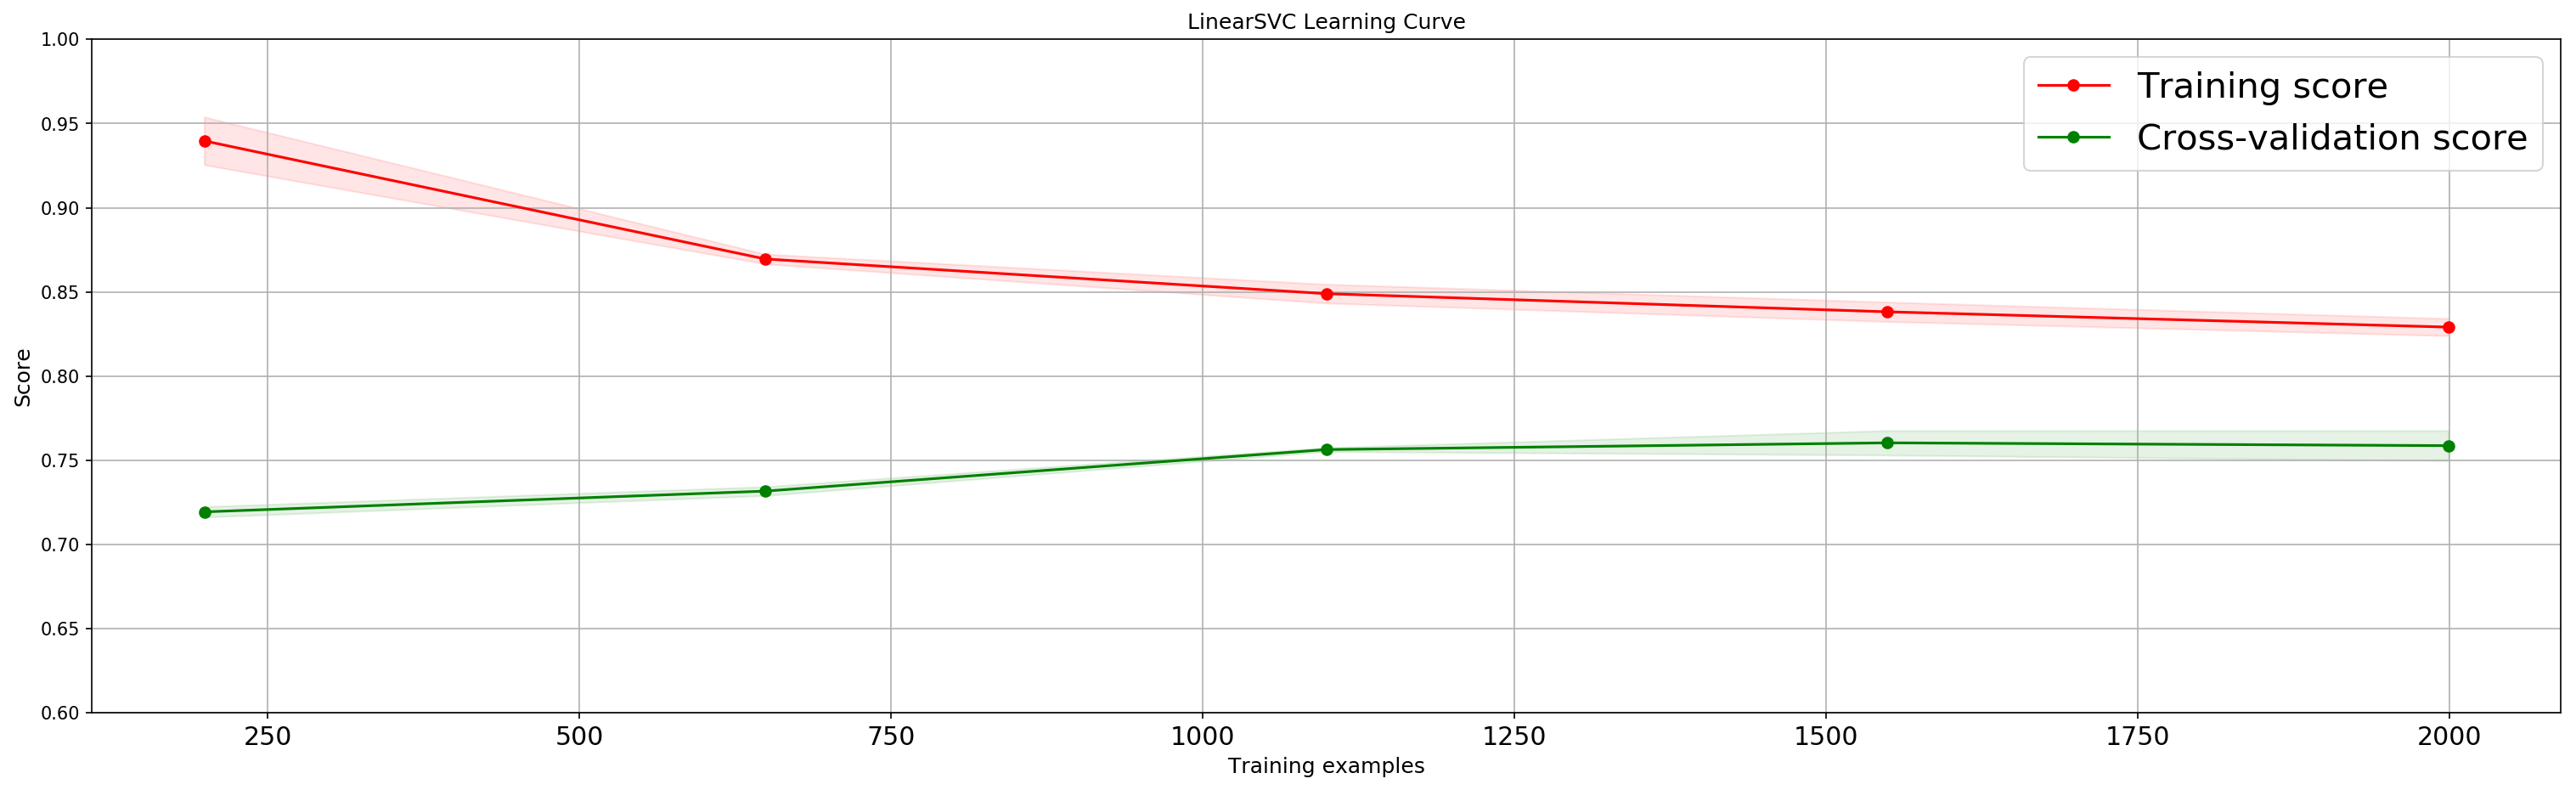

In [22]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(tree_clf, "LinearSVC Learning Curve", X_test, y_test, ylim=(0.6, 1.0), cv=3)   

In [23]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives, True Positives
# True Negatives, False Positives

confusion_matrix(y_test, y_pred_tree_clf)

array([[2044,  193],
       [ 509,  254]])

In [24]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_tree_clf)

0.5682326621923938

In [25]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_tree_clf)

0.3328964613368283

### Stochastic Gradient Descent

In [26]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=10)

In [27]:
start_time = time()
sgd_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.01s


In [28]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.75749786, 0.75782255, 0.57951136])

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

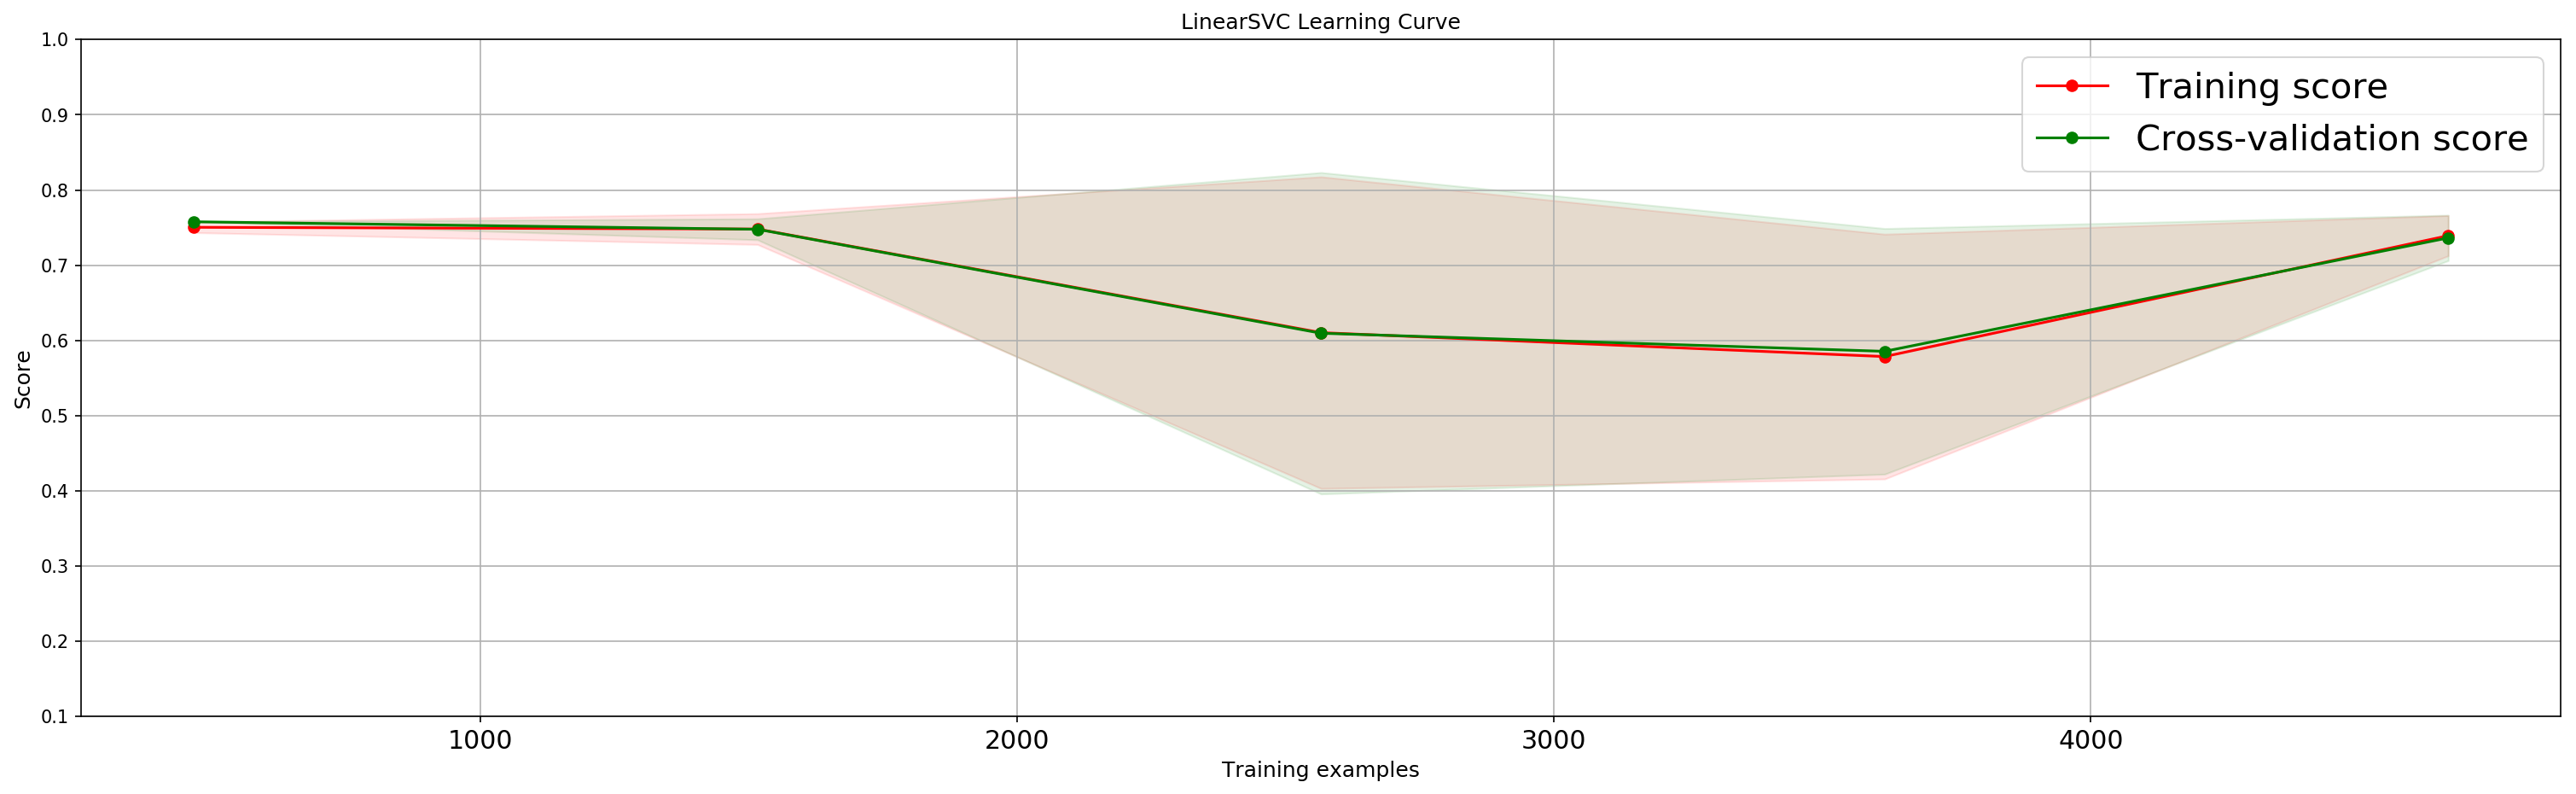

In [29]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(sgd_clf, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.1, 1.0), cv=3)    

In [30]:
y_train_pred_sgd_clf = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [31]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives, True Positives
# True Negatives, False Positives

confusion_matrix(y_train, y_train_pred_sgd_clf)

array([[4062, 1242],
       [ 867,  829]])

In [32]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="precision")

/Users/jsp22/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.52990033, 0.72727273, 0.        ])

In [33]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="recall")

array([0.65547703, 0.00353982, 0.01238938])

#### Test Data

In [34]:
y_pred_sgd_clf = sgd_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

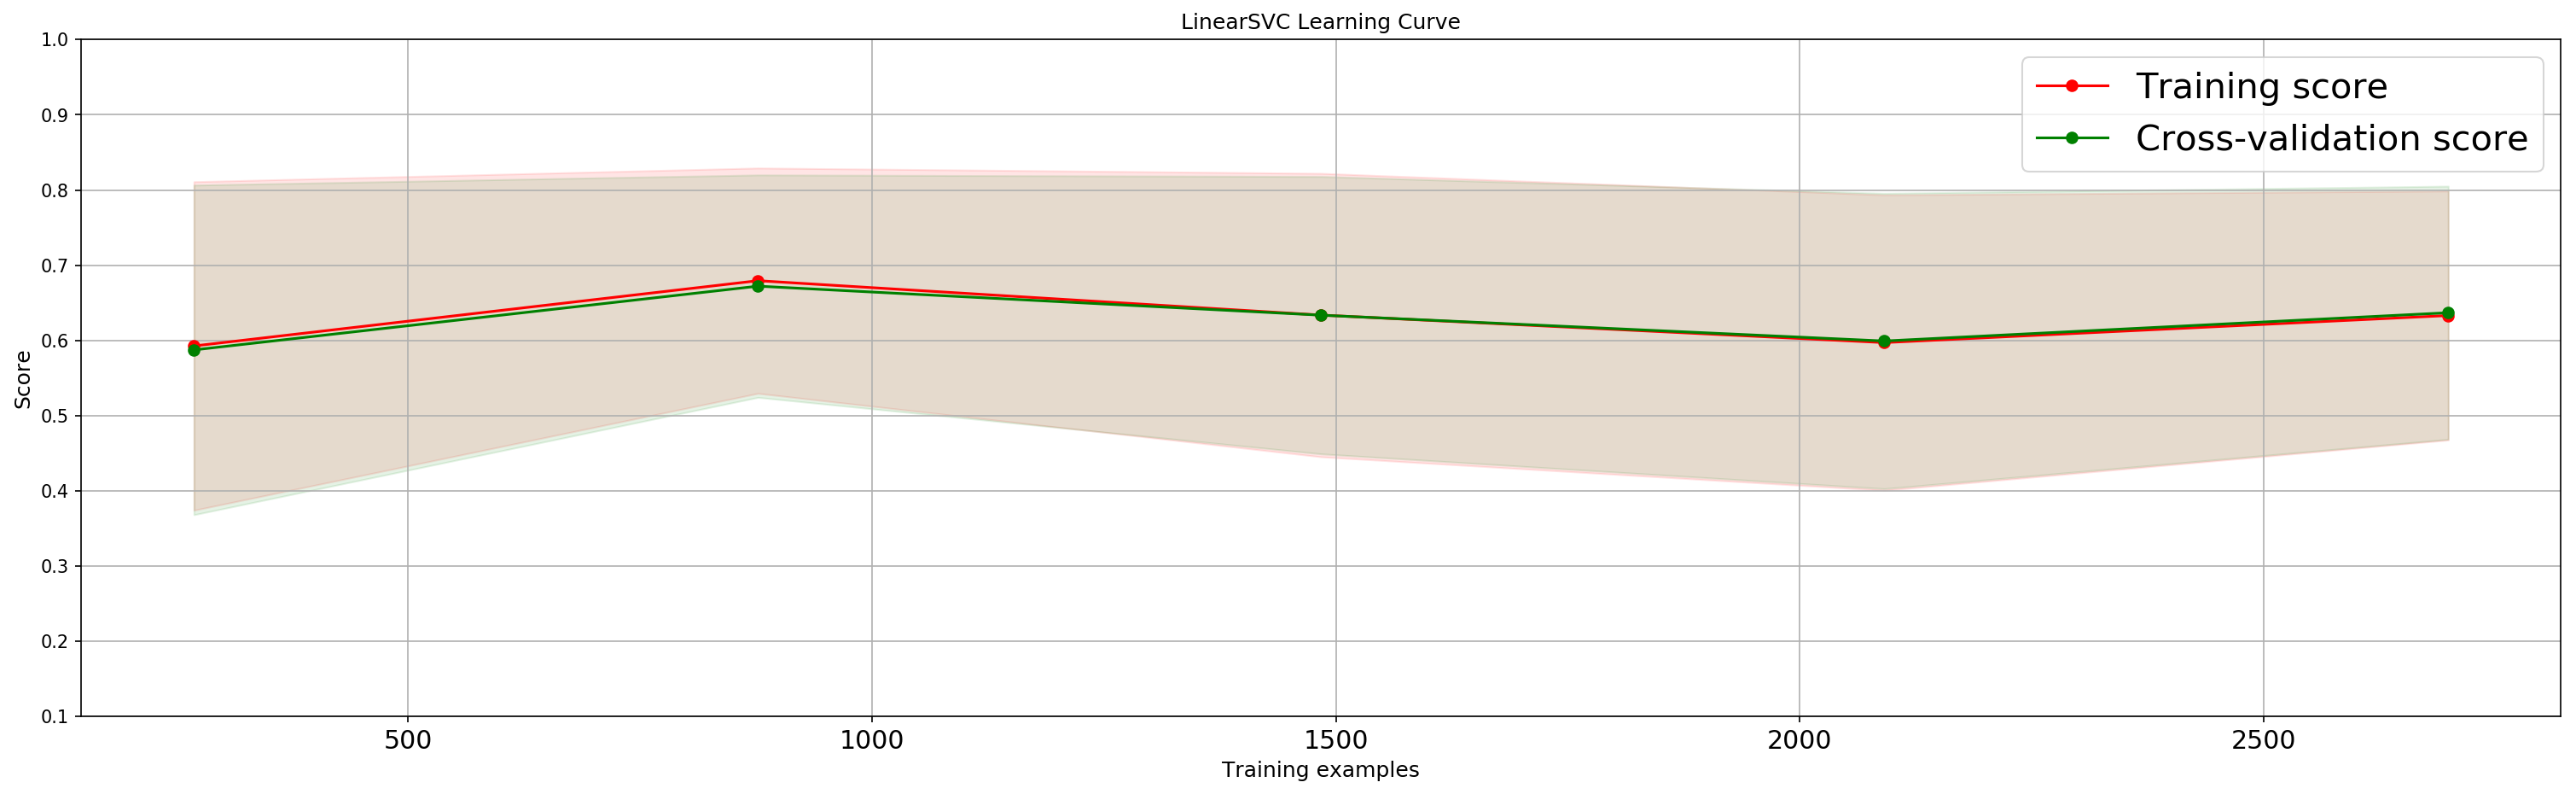

In [73]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(sgd_clf, "LinearSVC Learning Curve", X_test, y_test, ylim=(0.1, 1.0), cv=3)   

In [36]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives, True Positives
# True Negatives, False Positives

confusion_matrix(y_test, y_pred_sgd_clf)

array([[1962,  275],
       [ 415,  348]])

In [37]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_sgd_clf)

0.5585874799357945

In [38]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_sgd_clf)

0.45609436435124506

### Logistic Regression Classifier

In [39]:
from sklearn.linear_model import LogisticRegression
logit_clf = LogisticRegression(solver = 'lbfgs')

In [40]:
start_time = time()
logit_clf.fit(X_train, y_train)
print('Time elapsed: %.2fs' % (time()-start_time))

Time elapsed: 0.02s


In [41]:
# Cross Validated Accuracy - the proportion of prediction the model got right

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.78363325, 0.7663952 , 0.77925418])

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

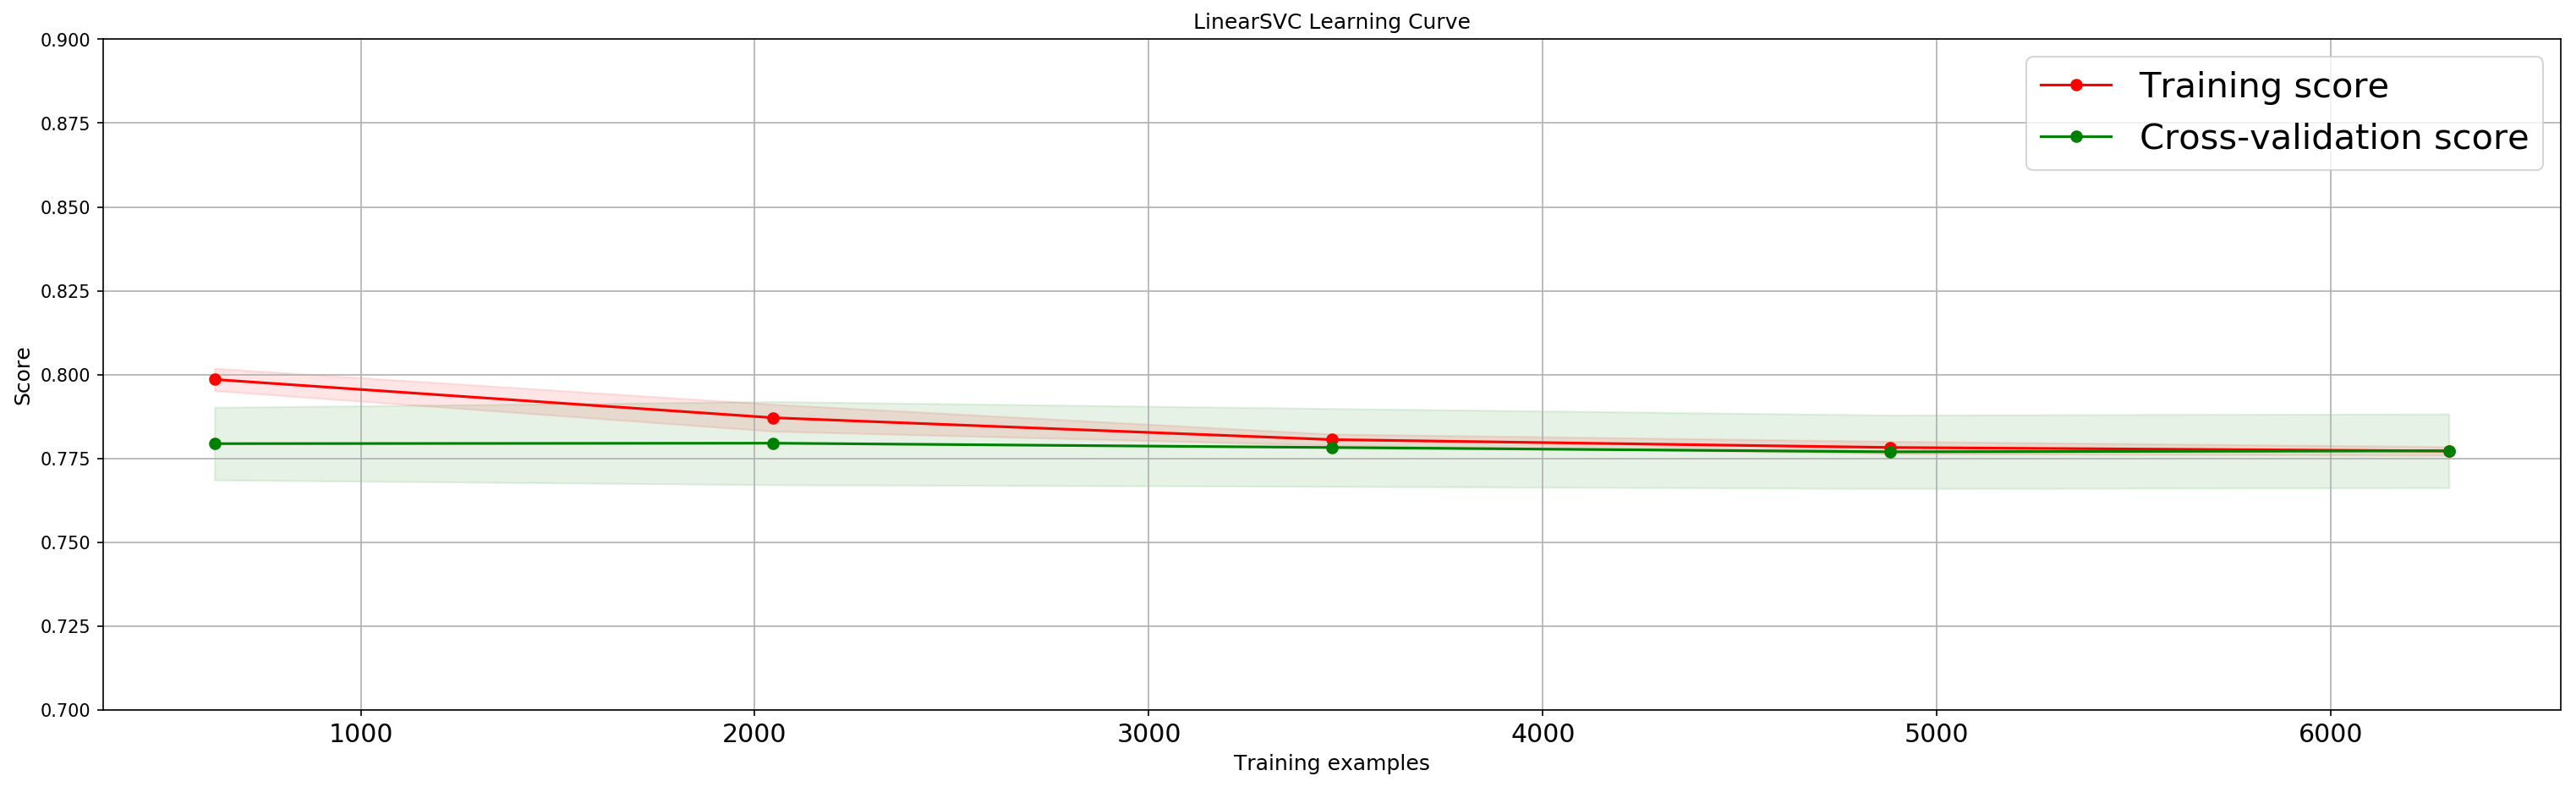

In [72]:
# Learning Curve - Plotting the model's performance on the training set.

plot_learning_curve(logit_clf, "LinearSVC Learning Curve", X_train, y_train, ylim=(0.7, 0.9), cv=3)   

In [43]:
y_train_pred_logit_clf = cross_val_predict(logit_clf, X_train, y_train, cv=3)

In [44]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives, True Positives
# True Negatives, False Positives

confusion_matrix(y_train, y_train_pred_logit_clf)

array([[4993,  311],
       [1254,  442]])

In [45]:
# Cross Validated Precision - the proportion of positive identifications that are actually correct split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="precision")

array([0.61509434, 0.54065041, 0.60330579])

In [46]:
# Cross Validated Recall - the proportion of actual positive that are identified correctly split into 3 folds.

cross_val_score(logit_clf, X_train, y_train, cv=3, scoring="recall")

array([0.28798587, 0.23539823, 0.25840708])

#### Test Data

In [47]:
y_pred_logit_clf = logit_clf.predict(X_test)

<module 'matplotlib.pyplot' from '/Users/jsp22/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

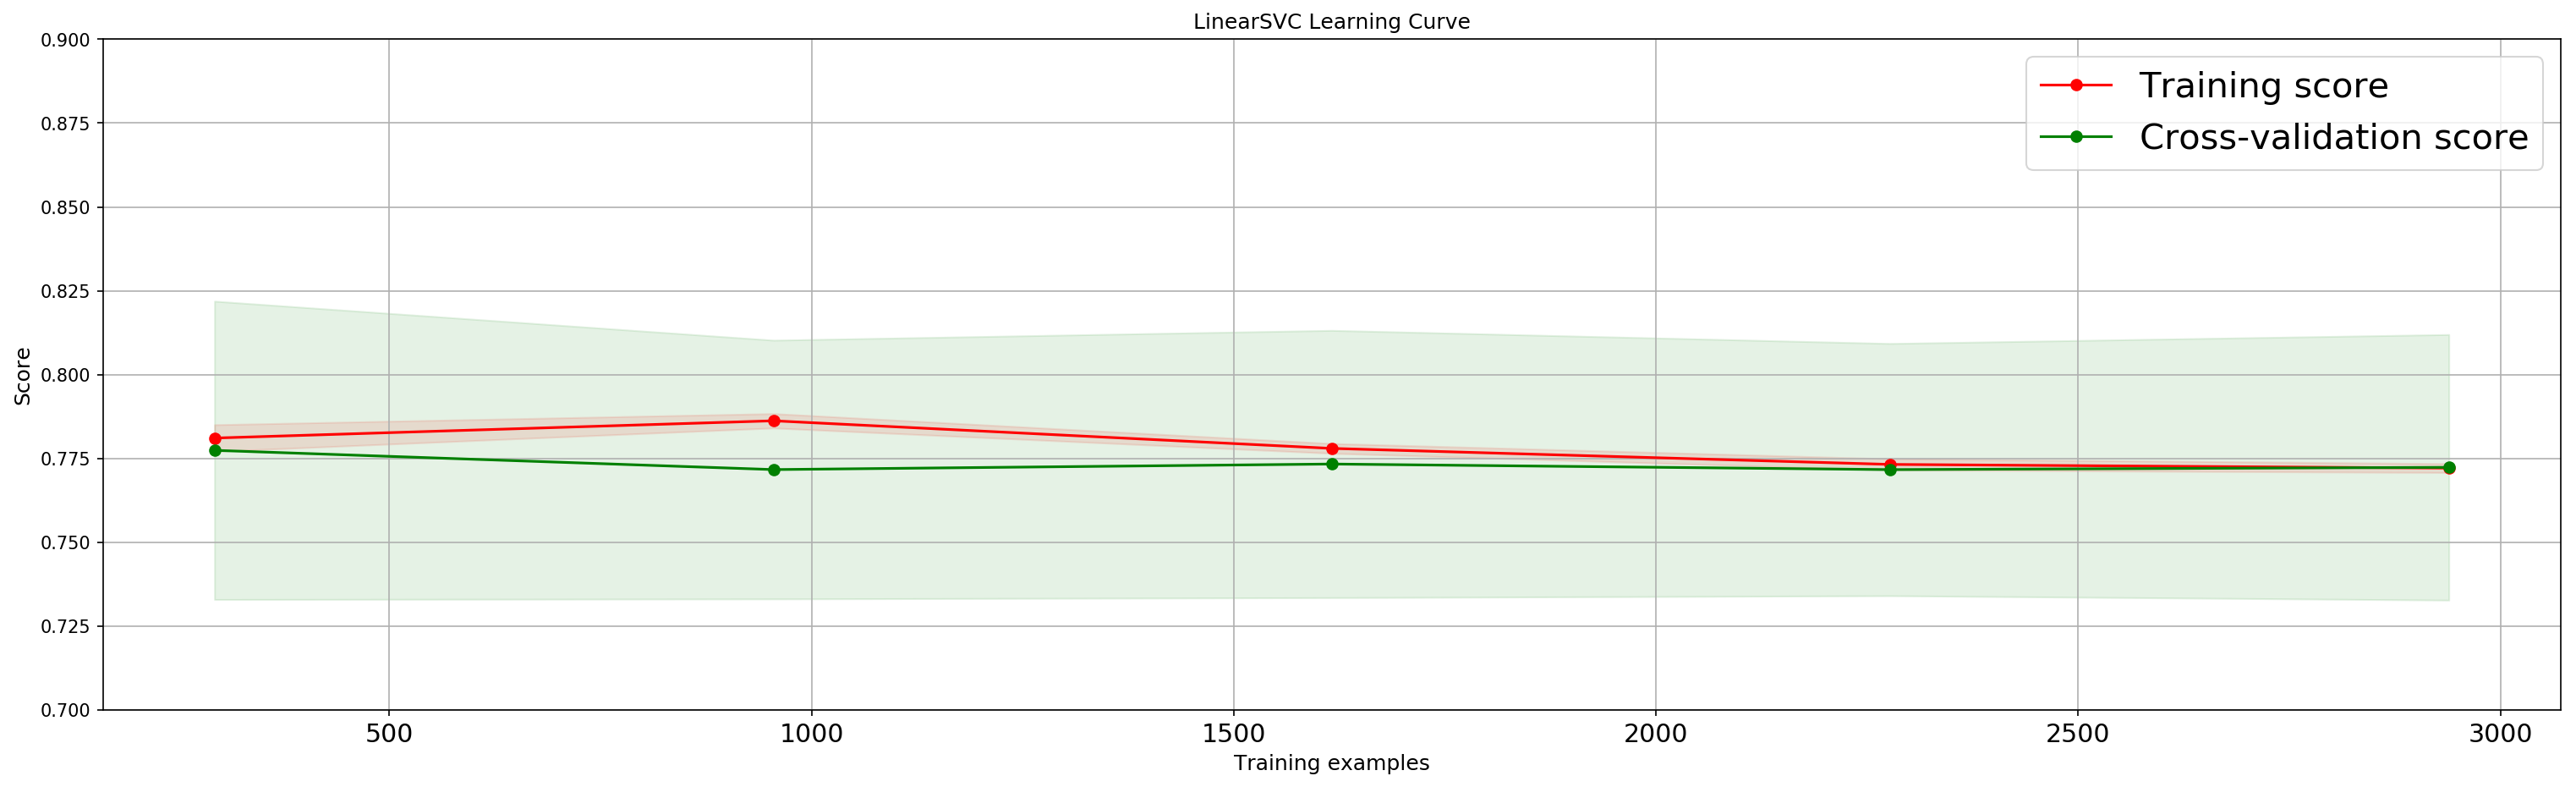

In [71]:
# Learning Curve - Plotting the model's performance on the test set.

plot_learning_curve(logit_clf, "LinearSVC Learning Curve", X_test, y_test, ylim=(0.7, 0.9), cv=3)   

In [49]:
# Confusion Matrix - Gives insight into the type of errors being made by the model. 
# False Negatives, True Positives
# True Negatives, False Positives

confusion_matrix(y_test, y_pred_logit_clf)

array([[2108,  129],
       [ 547,  216]])

In [50]:
#Precision - the proportion of positive identifications that are actually correct.

precision_score(y_test, y_pred_logit_clf)

0.6260869565217392

In [51]:
# Recall - the proportion of actual positive that are identified correctly. 

recall_score(y_test, y_pred_logit_clf)

0.28309305373525556

## Sex vs Salary

In [52]:
# drop columns won't be useful in analysis and prediction
data_sex = data.drop(['fnlwgt', 'education-num', 'education', 'race'], axis=1)

In [53]:
data_sex.head()

,age,workclass,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0
1,38,Private,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0
2,53,Private,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0
3,28,Private,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0
4,37,Private,Married-civ-spouse,Exec-managerial,Wife,Female,0,0,40,United-States,0


In [54]:
data_sex.shape

(32560, 11)

In [55]:
data_sex["sex"].value_counts()

 Male      21789
 Female    10771
Name: sex, dtype: int64

In [56]:
# group by Sex, Salary
grouped = data_sex.groupby(['sex','salary'])

In [57]:
grouped.salary.median()

sex      salary
 Female  0         0
         1         1
 Male    0         0
         1         1
Name: salary, dtype: int64

## apply 1-hot encoding to categorical features `Sex`

In [58]:
data_sex.dtypes

age                int64
workclass         object
marital-status    object
occupation        object
relationship      object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
salary             int64
dtype: object

In [59]:
data = pd.get_dummies(data, columns=['sex'], prefix = ['sex'])

In [60]:
data_sex.head()

,age,workclass,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,50,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,United-States,0
1,38,Private,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,United-States,0
2,53,Private,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,United-States,0
3,28,Private,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,Cuba,0
4,37,Private,Married-civ-spouse,Exec-managerial,Wife,Female,0,0,40,United-States,0


## Decreasing the sample size `n=100` for ease of use

In [61]:
data_sex.sample(n=100, random_state=10)

,age,workclass,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
11358,41,Private,Married-civ-spouse,Sales,Husband,Male,0,0,50,United-States,1
10859,38,Private,Married-civ-spouse,Sales,Husband,Male,0,0,60,United-States,1
30948,24,Private,Separated,Machine-op-inspct,Unmarried,Female,0,0,40,United-States,0
29811,35,Self-emp-inc,Separated,Prof-specialty,Not-in-family,Female,0,0,50,United-States,0
18408,69,?,Married-civ-spouse,?,Husband,Male,10605,0,10,United-States,1
2879,31,Private,Never-married,Handlers-cleaners,Other-relative,Male,0,0,40,United-States,0
21575,35,Private,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,45,United-States,0
26396,25,Private,Separated,Exec-managerial,Unmarried,Female,0,0,37,United-States,0
28644,56,Private,Married-civ-spouse,Exec-managerial,Husband,Male,15024,0,40,United-States,1
15694,22,Without-pay,Never-married,Handlers-cleaners,Own-child,Male,4416,0,40,United-States,0


## Race vs Salary

In [62]:
# drop columns won't be useful in analysis and prediction
data_race = data.drop(['fnlwgt', 'education-num', 'education','age'], axis=1)

In [63]:
data_race.head()

,workclass,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,salary,sex_ Female,sex_ Male
0,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,White,0,0,13,United-States,0,0,1
1,Private,Divorced,Handlers-cleaners,Not-in-family,White,0,0,40,United-States,0,0,1
2,Private,Married-civ-spouse,Handlers-cleaners,Husband,Black,0,0,40,United-States,0,0,1
3,Private,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,40,Cuba,0,1,0
4,Private,Married-civ-spouse,Exec-managerial,Wife,White,0,0,40,United-States,0,1,0


In [64]:
data_race.shape

(32560, 12)

## Decreasing the sample size `n=100` for ease of use

In [65]:
data_race.sample(n=100, random_state=10)

,workclass,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,salary,sex_ Female,sex_ Male
11358,Private,Married-civ-spouse,Sales,Husband,White,0,0,50,United-States,1,0,1
10859,Private,Married-civ-spouse,Sales,Husband,White,0,0,60,United-States,1,0,1
30948,Private,Separated,Machine-op-inspct,Unmarried,Other,0,0,40,United-States,0,1,0
29811,Self-emp-inc,Separated,Prof-specialty,Not-in-family,White,0,0,50,United-States,0,1,0
18408,?,Married-civ-spouse,?,Husband,White,10605,0,10,United-States,1,0,1
2879,Private,Never-married,Handlers-cleaners,Other-relative,White,0,0,40,United-States,0,0,1
21575,Private,Married-civ-spouse,Exec-managerial,Husband,White,0,0,45,United-States,0,0,1
26396,Private,Separated,Exec-managerial,Unmarried,White,0,0,37,United-States,0,1,0
28644,Private,Married-civ-spouse,Exec-managerial,Husband,White,15024,0,40,United-States,1,0,1
15694,Without-pay,Never-married,Handlers-cleaners,Own-child,White,4416,0,40,United-States,0,0,1


## Native-Country vs Salary

In [66]:
# drop columns won't be useful in analysis and prediction
data_country = data.drop(['fnlwgt', 'education-num', 'education','race'], axis=1)

In [67]:
data_country

,age,workclass,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,native-country,salary,sex_ Female,sex_ Male
0,50,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,0,0,13,United-States,0,0,1
1,38,Private,Divorced,Handlers-cleaners,Not-in-family,0,0,40,United-States,0,0,1
2,53,Private,Married-civ-spouse,Handlers-cleaners,Husband,0,0,40,United-States,0,0,1
3,28,Private,Married-civ-spouse,Prof-specialty,Wife,0,0,40,Cuba,0,1,0
4,37,Private,Married-civ-spouse,Exec-managerial,Wife,0,0,40,United-States,0,1,0
5,49,Private,Married-spouse-absent,Other-service,Not-in-family,0,0,16,Jamaica,0,1,0
6,52,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Husband,0,0,45,United-States,1,0,1
7,31,Private,Never-married,Prof-specialty,Not-in-family,14084,0,50,United-States,1,1,0
8,42,Private,Married-civ-spouse,Exec-managerial,Husband,5178,0,40,United-States,1,0,1
9,37,Private,Married-civ-spouse,Exec-managerial,Husband,0,0,80,United-States,1,0,1


## Decreasing the sample size `n=100` for ease of use

In [68]:
data_country.sample(n=100, random_state=10)

,age,workclass,marital-status,occupation,relationship,capital-gain,capital-loss,hours-per-week,native-country,salary,sex_ Female,sex_ Male
11358,41,Private,Married-civ-spouse,Sales,Husband,0,0,50,United-States,1,0,1
10859,38,Private,Married-civ-spouse,Sales,Husband,0,0,60,United-States,1,0,1
30948,24,Private,Separated,Machine-op-inspct,Unmarried,0,0,40,United-States,0,1,0
29811,35,Self-emp-inc,Separated,Prof-specialty,Not-in-family,0,0,50,United-States,0,1,0
18408,69,?,Married-civ-spouse,?,Husband,10605,0,10,United-States,1,0,1
2879,31,Private,Never-married,Handlers-cleaners,Other-relative,0,0,40,United-States,0,0,1
21575,35,Private,Married-civ-spouse,Exec-managerial,Husband,0,0,45,United-States,0,0,1
26396,25,Private,Separated,Exec-managerial,Unmarried,0,0,37,United-States,0,1,0
28644,56,Private,Married-civ-spouse,Exec-managerial,Husband,15024,0,40,United-States,1,0,1
15694,22,Without-pay,Never-married,Handlers-cleaners,Own-child,4416,0,40,United-States,0,0,1
